### Feedforward network with geodesic distance metric


In [50]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from ratinabox.Environment import Environment
from scipy import stats
import os

from tqdm import tqdm

from src.models import ContextSpaceNet
from src.data_generation import generate_random_trajectories, generate_random_samples
from src.utils import ratemap_collage

(<Figure size 300x300 with 1 Axes>, <Axes: >)

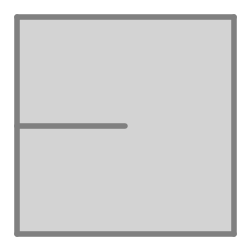

In [19]:
# Generate environment with wall
env = Environment()
env.add_wall([[0, 0.5], [0.5, 0.5]])
env.plot_environment()

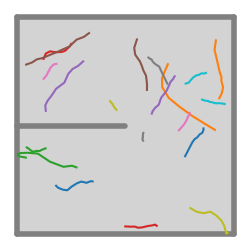

In [22]:
# Generate random trajectories
r, v = generate_random_trajectories(env, n_traj=20, timesteps=10, dt=0.1, speed_mean=0.25)
fig, ax = env.plot_environment()
for traj_id in range(20):
    ax.plot(r[traj_id, :, 0], r[traj_id, :, 1])
plt.show()

In [25]:
samples = generate_random_samples(env, n_samples=1000)

In [27]:
samples.shape

torch.Size([1000, 2])

In [54]:
train_steps = 50000
n_in = 2        # 2 position
n_out = 100     # no. of spatial representations
bs = 128        # batch size
scale = 0.1     # scale of the gaussian kernel
lam = 0.001     # regularization parameter
lr = 1e-3       # learning rate

# Initialize model and optimizer
model = ContextSpaceNet(n_in, n_out, scale=scale, lam=lam)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_history = []
progress = tqdm(range(train_steps))
for m in progress:

    # Generate random positions
    # r = torch.tensor(np.random.uniform(-1, 1, (bs, 2)), dtype=torch.float32)
    r = generate_random_samples(env, n_samples=bs)

    # Reset optimizer
    optimizer.zero_grad()

    # Compute spatial representation
    p = model.spatial_representation(r)  # ns, nr

    # Compute pairwise distances of representations, apply exponential
    dp = torch.pdist(p) **2
    corr = torch.exp(-dp)

    # Compute pairwise distances of positions, here we use the geodesic distance
    dr = np.triu(env.get_distances_between___accounting_for_environment(r, r, wall_geometry="geodesic", return_vectors=False), k=1) ** 2

    # Get the indices of the upper right triangle (excluding the main diagonal)
    i, j = np.triu_indices(dr.shape[0], k=1)

    # Create tensor
    dr = torch.tensor(dr[i, j], dtype=torch.float32)

    # Compute the correlation
    label_corr = torch.exp(-0.5 / scale ** 2 * dr)

    # Compute loss
    loss = torch.mean((corr - label_corr) ** 2)
    loss = loss + lam*torch.mean(p**2)

    # Backprop
    loss.backward()
    optimizer.step()

    if m % 10 == 0:
        loss_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")

loss: 0.000072: 100%|██████████| 50000/50000 [08:10<00:00, 101.85it/s]


In [57]:
# Evaluate on 2x2 grid
n = 32
x = np.linspace(0, 1, n)
y = x.copy()
xx, yy = np.meshgrid(x, y)
u = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis=-1), dtype=torch.float32)

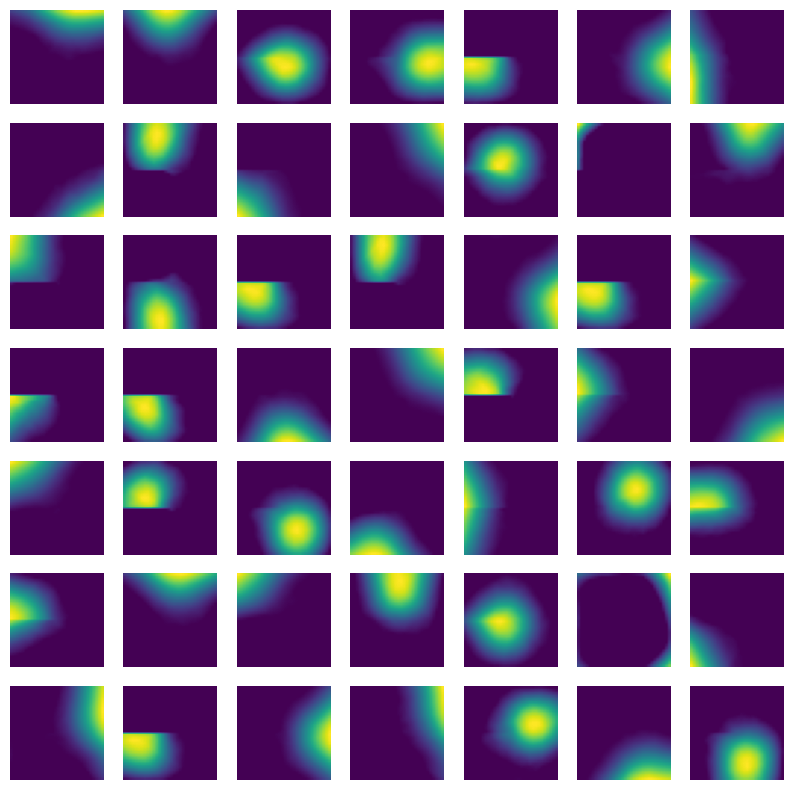

In [59]:
# Get spatial representations
p = model.spatial_representation(u)
p = p.detach().numpy()

p = np.swapaxes(p.T.reshape(-1, n, n), 2, 1) # reshape to (n_out, n, n)
# p = p.T.reshape(-1, n, n) # reshape to (n_out, n, n)

# Get mask of active units
mask = np.sum(p, axis=(1, 2)) > 0
p = p[mask]

# Plot ratemaps
fig, ax = ratemap_collage(p[:49], cols=7, figsize=(10, 10))